In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC  
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
import nltk

%matplotlib inline

In [2]:
# !pip install emoji

In [3]:
train = pd.read_csv("../Hackathon3/data/train.csv",encoding='utf-8')
test=pd.read_csv("../Hackathon3/data/test.csv",encoding='utf-8')
pd.set_option('max_colwidth',150)
train.head(10)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1
5,966,#technews One lone dude awaits iPad 2 at AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech,1
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping With Zuckerberg.\r\n{link} #sxsw #ipad",1
7,8182,NU user RT @mention New #UberSocial for #iPhone now in the App Store includes UberGuide to #SXSW sponsored by #Mashable,1
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2
9,883,I think I might go all weekend without seeing the same iPad case twice... #sxsw,2


In [4]:
train['sentiment'].value_counts()

1    4311
2    2382
0     456
3     125
Name: sentiment, dtype: int64

### Treating Slangs

We scraped the website : "https://www.webopedia.com/quick_ref/textmessageabbreviations.asp"
and obtained the table of slang words with their meanings 

In [5]:
slangs_df = pd.read_csv("../Hackathon3/slangs_df.csv")
slangs_df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [6]:
slangs_df.head(10)

,Slangs,Full_Forms
0,?,I have a question
1,?,I don't understand what you mean
2,?4U,I have a question for you
3,;S,"Gentle warning, like ""Hmm? What did you say?"""
4,^^,"Meaning ""read line"" or ""read message"" above"
5,<3,"Meaning ""sideways heart"" (love, friendship)"
6,<3,"Meaning ""broken heart"""
7,<33,"Meaning ""heart or love"" (more 3s is a bigger heart)"
8,@TEOTD,At the end of the day
9,.02,My (or your) two cents worth


In [7]:
def df_to_dict(df,df_dict):
    for index,row in df.iterrows():
        df_dict[row['Slangs']] = row['Full_Forms']
    return df_dict

slangs_dict = {}
slangs_dict = df_to_dict(slangs_df,slangs_dict)
slangs_dict['PC'] = "Personal Computer"

In [8]:
train=train.astype(str)
test=test.astype(str)
def treat_slangs(row,slang_dict):
    words = row.split()
    treated_row = []
    reformed = []
    for word in words:
        if word.upper() in slang_dict.keys():
            new_word = word.replace(word,slang_dict[word.upper()])
            treated_row.append(new_word)
        else:
            treated_row.append(word)
    reformed = " ".join(treated_row)
    return reformed
train['tweet'] = train['tweet'].apply(lambda x:treat_slangs(x,slangs_dict))
test['tweet'] = test['tweet'].apply(lambda x:treat_slangs(x,slangs_dict))

In [9]:
chat_words_str = """AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you 
ILU=I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My Ass Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My Ass Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The Fuck
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait
7K=Sick
YRS=Years
MKT=Market"""

chat_words_str = chat_words_str.replace("\n",":")
chat_words_split = chat_words_str.split(":")
slangs = list(chat_words_split)

In [10]:
###
slangs_words = []
full_forms = []
for slang in slangs:
    new_slang = slang.split("=")
    slangs_words.append(new_slang[0])
    full_forms.append(new_slang[1])

In [11]:
###
slang_words_small = {}
for i in range(len(slangs_words)):
    slang_words_small[slangs_words[i]] = full_forms[i]

In [12]:
## Treating apostrophes
apostrophes = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"'s" : " ",
"'m" : " am"
}

In [13]:
def apostrophe_correction(row):
    words = row.split()
    cleaned_row = []
    for word in words:
        for apostrophe in apostrophes:
            if apostrophe in word:
                word = word.replace(apostrophe, apostrophes[apostrophe]) 
        cleaned_row.append(word)
    reformed = " ".join(cleaned_row)
    return reformed
train['tweet']=train.tweet.apply(apostrophe_correction)
test['tweet']=test.tweet.apply(apostrophe_correction)

In [14]:
train.head(10)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,2689,"one of the most in-your-face ex. of stealing the show in yrs Roger that @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,4525,This iPhone #SXSW Appreciate would Be pretty awesome if it did not crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1
5,966,"#technews One lone dude awaits iPad Meaning ""to"" in SMS At your terminal AppleÛªs SXSW store {link} #Tech_News #Apple #iPad_2 #SXSW #tablets #tech",1
6,1395,"SXSW Tips, Prince, NPR Videos, Thinking of you Shopping With Zuckerberg. {link} #sxsw #ipad",1
7,8182,NU user Roger that @mention New #UberSocial for #iPhone now in the Appreciate Store includes UberGuide to #SXSW sponsored by #Mashable,1
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2
9,883,I think I might go all weekend without seeing the same iPad case twice... #sxsw,2


#### Remove Special characters
Eg : Ã‰ -> É â€œ -> " â€ -> " Ã‡ -> Ç Ãƒ -> Ã Ã©, 'é Ã -> À Ãº -> ú â€¢ -> - Ã˜ -> Ø Ãµ -> õ Ã­ -> í Ã¢ -> â Ã£ -> ã Ãª -> ê Ã¡ -> á Ã© -> é Ã³ -> ó â€“ -> – Ã§ -> ç Âª -> ª Âº -> º Ã -> à

In [15]:
import html
def remov_pattern(pattern,text):
    text = re.sub(pattern,'',text)
    return text

pattern = "[^a-zA-Z\s#]" 
train['tweet'] = train['tweet'].apply(lambda x:remov_pattern(pattern,x))
test['tweet'] = test['tweet'].apply(lambda x:remov_pattern(pattern,x))

#Eg: &quot;,&amp;
train['tweet'] = train['tweet'].apply(lambda x:html.unescape(x))
test['tweet'] = test['tweet'].apply(lambda x:html.unescape(x))

In [16]:
train.head(10)

,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,1851,Learning ab Google doodles All doodles should be light funny amp innovative with exceptions for significant occasions #GoogleDoodle #sxsw,1
2,2689,one of the most inyourface ex of stealing the show in yrs Roger that mention quotAt #SXSW Apple schools the mkt expertsquot link,2
3,4525,This iPhone #SXSW Appreciate would Be pretty awesome if it did not crash every mins during extended browsing #Fuckit #Illmakeitwork,0
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW link,1
5,966,#technews One lone dude awaits iPad Meaning to in SMS At your terminal Apples SXSW store link #TechNews #Apple #iPad #SXSW #tablets #tech,1
6,1395,SXSW Tips Prince NPR Videos Thinking of you Shopping With Zuckerberg link #sxsw #ipad,1
7,8182,NU user Roger that mention New #UberSocial for #iPhone now in the Appreciate Store includes UberGuide to #SXSW sponsored by #Mashable,1
8,8835,Free #SXSW sampler on iTunes link #FreeMusic,2
9,883,I think I might go all weekend without seeing the same iPad case twice #sxsw,2


In [17]:
## Adding hashtags as separate column
train['hashtags'] = train['tweet'].apply(lambda x:','.join(re.findall("#[\w]*",x)))
train['hashtags'] = train['hashtags'].apply(lambda x:re.sub("[#]*","",x))
train['hashtags'] = train['hashtags'].apply(lambda x:x.lower())

test['hashtags'] = test['tweet'].apply(lambda x:','.join(re.findall("#[\w]*",x)))
test['hashtags'] = test['hashtags'].apply(lambda x:re.sub("[#]*","",x))
test['hashtags'] = test['hashtags'].apply(lambda x:x.lower())

In [18]:
train.head()

,tweet_id,tweet,sentiment,hashtags
0,1701,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1,"sxswnui,sxsw,apple"
1,1851,Learning ab Google doodles All doodles should be light funny amp innovative with exceptions for significant occasions #GoogleDoodle #sxsw,1,"googledoodle,sxsw"
2,2689,one of the most inyourface ex of stealing the show in yrs Roger that mention quotAt #SXSW Apple schools the mkt expertsquot link,2,sxsw
3,4525,This iPhone #SXSW Appreciate would Be pretty awesome if it did not crash every mins during extended browsing #Fuckit #Illmakeitwork,0,"sxsw,fuckit,illmakeitwork"
4,3604,Line outside the Apple store in Austin waiting for the new iPad #SXSW link,1,sxsw


In [19]:
test.head()

,tweet_id,tweet,hashtags
0,7506,Audience Q What prototyping tools do you use Sketchbookssharpie pens photoshop Balsamic Google docs Axsure etc #myprototype #sxsw,"myprototype,sxsw"
1,7992,At your terminal SXSW Send Your Best Photos amp Videos to link #citizenjournalism #cnn #ireport #photography #sxsw #Cyber #iPhone,"citizenjournalism,cnn,ireport,photography,sxsw,cyber,iphone"
2,247,mention and here a Picture of you winning your ipad #unsix #sxsw cc mention mention link cont link,"unsix,sxsw"
3,7688,Google Marissa Mayer mobile phone as a cursor of physical location new version of map fast and more real life like #sxsw,sxsw
4,3294,#SXSW Google maps is even cooler than I thought,sxsw


In [20]:
train['hashtags'] = train['hashtags'].apply(lambda x: re.sub(","," ",x))
train['tweet'] = train['tweet'].apply(lambda x:re.sub("#[\w]*",'',x))
train['tweet'] = train['tweet'].str.lower()

test['hashtags'] = test['hashtags'].apply(lambda x: re.sub(","," ",x))
test['tweet'] = test['tweet'].apply(lambda x:re.sub("#[\w]*",'',x))
test['tweet'] = test['tweet'].str.lower()

In [21]:
train['tweet'] = train['tweet'].apply(lambda x:re.sub(r"\brt","",x,flags=re.IGNORECASE))
test['tweet'] = test['tweet'].apply(lambda x:re.sub(r"\brt","",x,flags=re.IGNORECASE))

In [22]:
train.head()

,tweet_id,tweet,sentiment,hashtags
0,1701,defining language of touch with different dialects becoming smaller,1,sxswnui sxsw apple
1,1851,learning ab google doodles all doodles should be light funny amp innovative with exceptions for significant occasions,1,googledoodle sxsw
2,2689,one of the most inyourface ex of stealing the show in yrs roger that mention quotat apple schools the mkt expertsquot link,2,sxsw
3,4525,this iphone appreciate would be pretty awesome if it did not crash every mins during extended browsing,0,sxsw fuckit illmakeitwork
4,3604,line outside the apple store in austin waiting for the new ipad link,1,sxsw


In [23]:
## STOP WORDS REMOVAL

sxsw_patterns = []
def find_pattern(df,pattern):
    r = re.findall(pattern,df)
    for i in r:
        if i not in sxsw_patterns:
            sxsw_patterns.append(i)
pattern = "sxsw[\w]*"
train['tweet'].apply(lambda x:find_pattern(x,pattern))
test['tweet'].apply(lambda x:find_pattern(x,pattern))

0       None
1       None
2       None
3       None
4       None
        ... 
1814    None
1815    None
1816    None
1817    None
1818    None
Name: tweet, Length: 1819, dtype: object

In [24]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', str(input_text))
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', str(input_text))
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', str(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
#     def stemming(self, input_text):
#         porter = PorterStemmer()
#         words6 = input_text.split() 
#         stemmed_words = [porter.stem(word) for word in words]
#         return " ".join(stemmed_words)
    
    def lemmatization(self,input_text):
        words = input_text.split() 
        lemma = WordNetLemmatizer()
        lemma_words = [lemma.lemmatize(i) for i in words]
        return " ".join(lemma_words)  
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.lemmatization)
        return clean_X

In [25]:
# from string import punctuation
# stop_words = list(set(stopwords.words('english')))+list(punctuation)
# train['tweet'] = train['tweet'].apply(lambda x:word_tokenize(x))
# train['tweet'] = train['tweet'].apply(lambda row:[word for word in row if word not in stop_words])

In [26]:
# lemma = WordNetLemmatizer()
# train['tweet'] = train['tweet'].apply(lambda x:[lemma.lemmatize(i) for i in x])
# train['tweet'] = train['tweet'].apply(lambda x:' '.join(x))

In [27]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self

    def transform(self, X, **transform_params):
        def has_long(sentence):
            a = []
            for x in sentence.split():
                if re.compile("([a-zA-Z])\\1{2,}").search(x):
                    a.append(x)
            return a
        def isalpha(stre):
            countl=0
            for i in stre:
                if i.isalpha():
                    countl+=1
            return countl
        def isdig(stre):
            countn=0
            for i in stre:
                if i.isdigit():
                    countn+=1
            return countn
        fstcap = X.apply(lambda a:len([''.join(c) for c in a.strip().split() if c[0].isupper()])) # list of first capital letter
        elgwrd = X.apply(lambda a:len(has_long(a))) # list of Elongated word
        NofChr = X.apply(lambda a:isalpha(a)) # number of character
        Nofdgt = X.apply(lambda a:isdig(a)) # number of digit
        count_words = X.apply(lambda x: self.count_regex(r'\w+', str(x)))   # count word 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', str(x)))  # count mentions
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', str(x)))  # count hashtags
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', str(x)))   # count uppercase words
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', str(x)))     # count exclametory mark
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', str(x)))  # count urls
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(str(x))).apply(lambda x: self.count_regex(r':[a-z_&]+:', str(x)))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_char': NofChr
                           , 'count_digit': Nofdgt
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_fCap': fstcap
                           , 'count_Elgwords': elgwrd
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df


In [28]:
df = train  # load train data
df1 = test # load test data

# create numerical feature for train
tc = TextCounts()
df_train = tc.fit_transform(df['tweet'])
df_train['sentiment'] = df.sentiment
# create numerical feature for test
df_test = tc.fit_transform(df1['tweet'])
# clean text for train 
ct = CleanText()
train_clean = ct.fit_transform(df['tweet'])
# clean text for test 
ct = CleanText()
test_clean = ct.fit_transform(df1['tweet'])

df_model = df_train
df_model['clean_text'] = train_clean
df1_model = df_test
df1_model['clean_text'] = test_clean

In [29]:
#  nltk.download('wordnet')

In [30]:
train_clean.sample(5)

4559                                                                             msft panel touch interface show bunch tablet no ipad
770                                                          crowd austin swarm ipad meaning sm launch link via mention sadly not one
7160                             course ha roger mention mention apple opening temporary store austin amp ipad meaning sm launch link
6015    roger mention hm whatever need another roger mention google launch major new social network called circle possibly today link
5288                                                geek leave austin music people hit town look feel becomes unique le apple branded
Name: tweet, dtype: object

In [31]:
empty_clean = train_clean == ''
print('{} records have no words left after text cleaning'.format(train_clean[empty_clean].count()))
train_clean.loc[empty_clean] = '[no_text]'

1 records have no words left after text cleaning


In [32]:
df1_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,clean_text
0,16,95,0,0,0,0,0,0,0,0,0,audience prototyping tool use sketchbookssharpie pen photoshop balsamic google doc axsure etc
1,12,51,0,0,0,0,0,0,0,0,0,terminal sxsw send best photo amp video link
2,16,70,0,0,0,0,0,0,0,0,0,mention picture winning ipad cc mention mention link cont link
3,21,94,0,0,0,0,0,0,0,0,0,google marissa mayer mobile phone cursor physical location new version map fast real life like
4,8,34,0,0,0,0,0,0,0,0,0,google map even cooler thought


In [33]:
df_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text
0,9,59,0,0,0,0,0,0,0,0,0,1,defining language touch different dialect becoming smaller
1,17,101,0,0,0,0,0,0,0,0,0,1,learning ab google doodle doodle light funny amp innovative exception significant occasion
2,22,101,0,0,0,0,0,0,0,0,0,2,one inyourface ex stealing show yr roger mention quotat apple school mkt expertsquot link
3,17,86,0,0,0,0,0,0,0,0,0,0,iphone appreciate would pretty awesome not crash every min extended browsing
4,13,56,0,0,0,0,0,0,0,0,0,1,line outside apple store austin waiting new ipad link


Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0           456.0  18.333333  6.002808  5.0  14.0  18.0  22.0  38.0
1          4311.0  16.963814  6.044390  0.0  13.0  17.0  21.0  44.0
2          2382.0  18.106213  6.027660  2.0  14.0  18.0  22.0  47.0
3           125.0  17.224000  6.296266  6.0  12.0  16.0  22.0  32.0


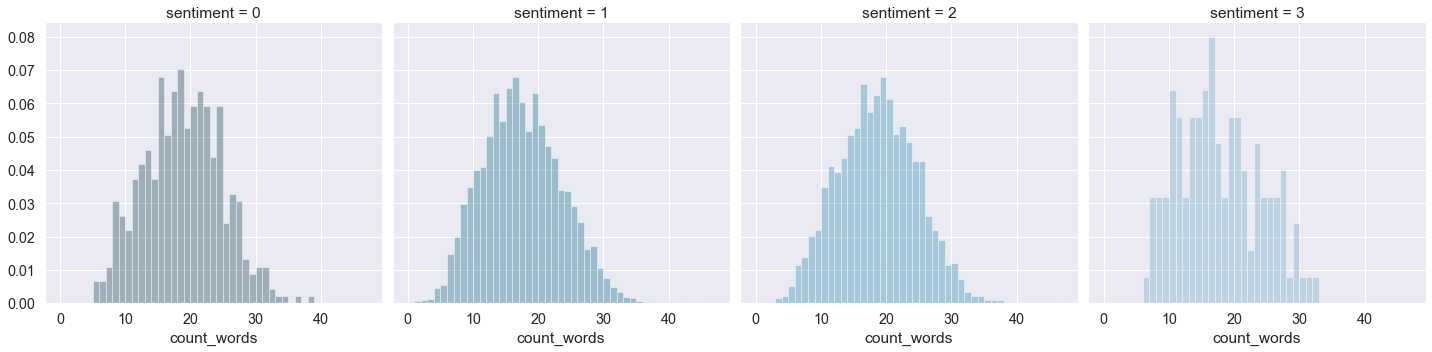

Descriptive stats for count_mentions
------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0           456.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          2382.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3           125.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


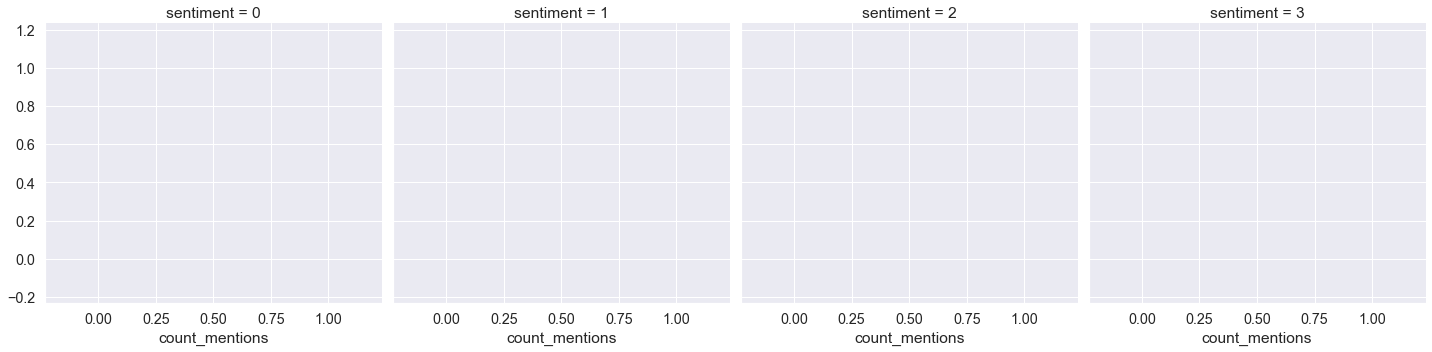

Descriptive stats for count_hashtags
------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0           456.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          2382.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3           125.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


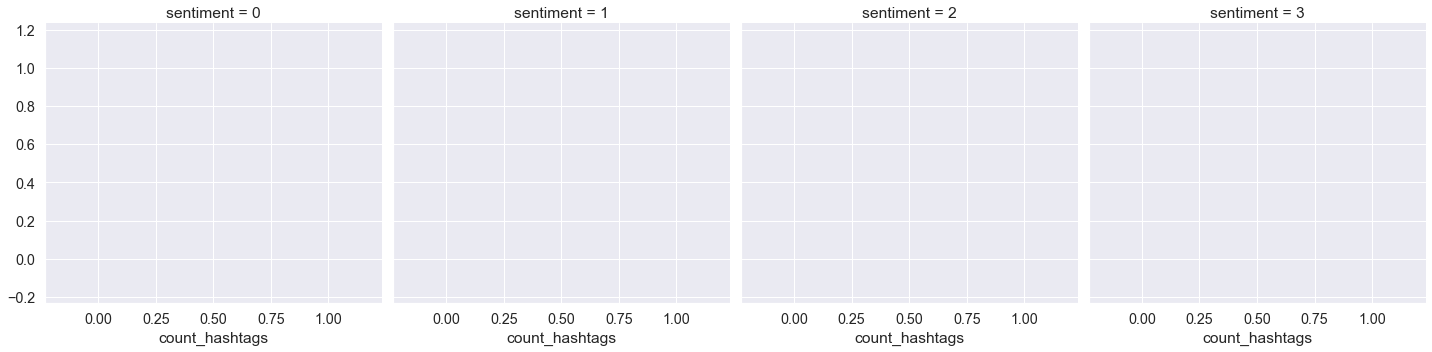

Descriptive stats for count_capital_words
-----------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0           456.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          2382.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3           125.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


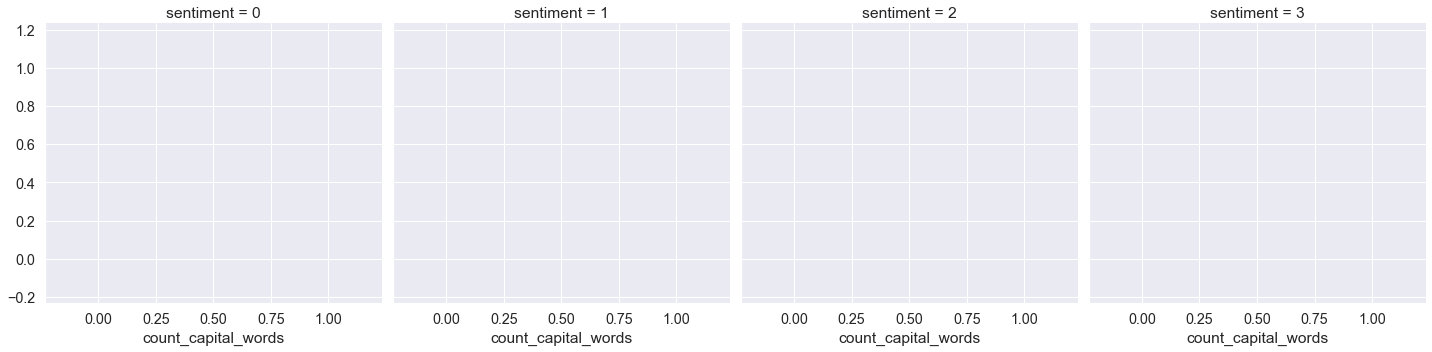

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0           456.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          2382.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3           125.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


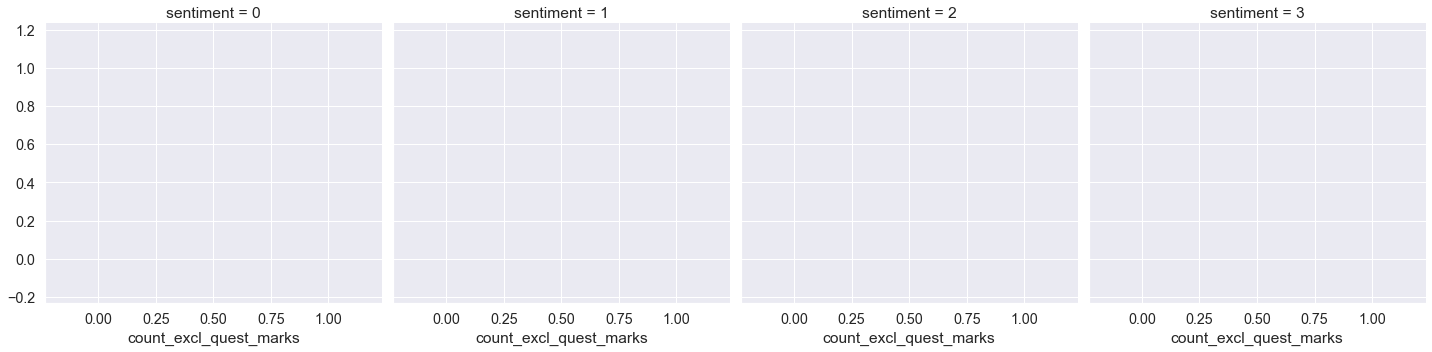

Descriptive stats for count_urls
--------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0           456.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          2382.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3           125.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


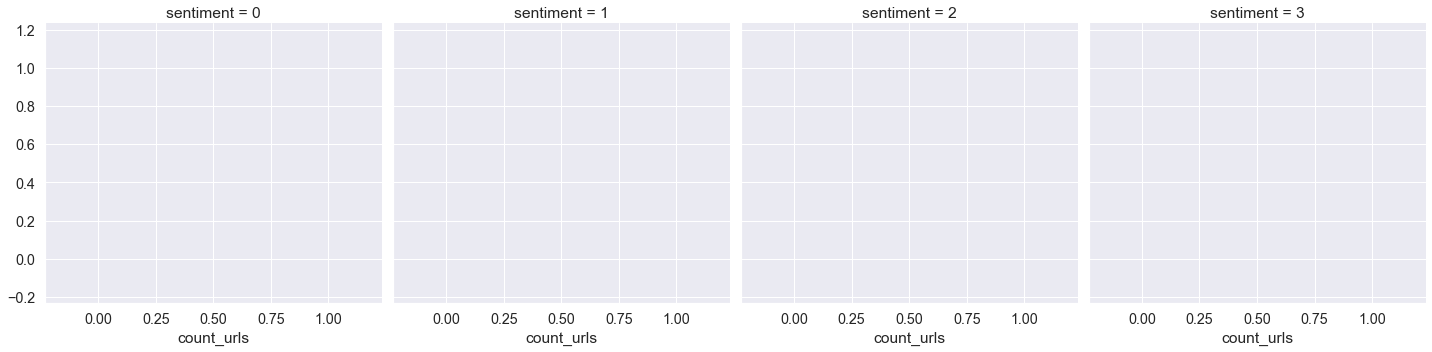

Descriptive stats for count_emojis
----------------------------------
            count  mean  std  min  25%  50%  75%  max
sentiment                                            
0           456.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1          4311.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2          2382.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
3           125.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


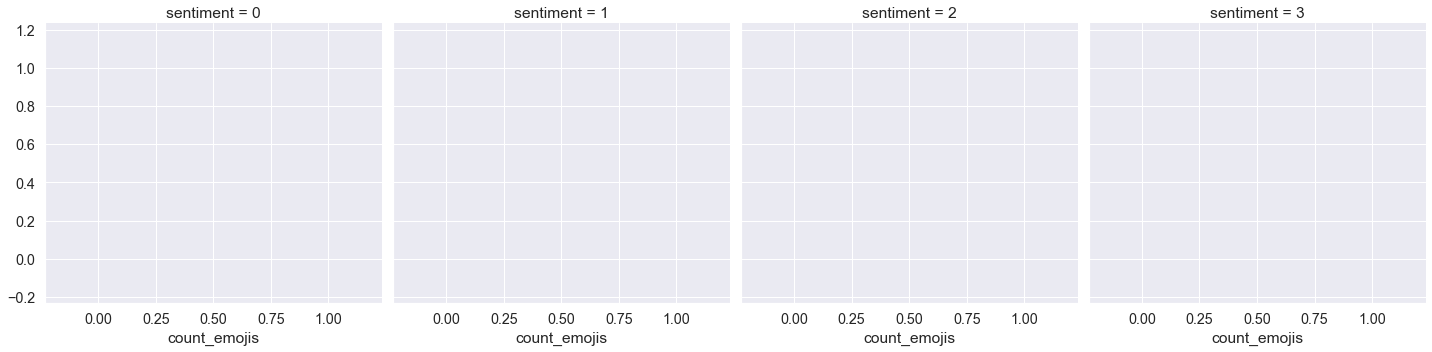

In [34]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    
df_eda = df_model
show_dist(df_eda, 'count_words')
show_dist(df_eda, 'count_mentions')
show_dist(df_eda, 'count_hashtags')
show_dist(df_eda, 'count_capital_words')
show_dist(df_eda, 'count_excl_quest_marks')
show_dist(df_eda, 'count_urls')
show_dist(df_eda, 'count_emojis')

In [35]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)


In [36]:
f1 = []
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
    print('Train Accuracy:\n',model.score(X_train,y_train).round(3))
    print('Validation Accuracy:\n',model.score(X_test,y_test).round(3))
    print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='weighted').round(3))
    print("Recall Score : ",recall_score(y_test, y_scores,average='weighted').round(3))

    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='weighted').round(3))
    f1.append(f1_score(y_test, y_scores,average='weighted').round(3))
    print("="*120)
    return f1


In [37]:
# Predictors
X = Xt
y = df_model['sentiment']

models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)}

j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a = run_model(X, y, model)
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.803
Validation Accuracy:
 0.665
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.03      0.06        93
           1       0.68      0.87      0.77       861
           2       0.62      0.45      0.52       478
           3       0.00      0.00      0.00        23

    accuracy                           0.67      1455
   macro avg       0.40      0.34      0.34      1455
weighted avg       0.63      0.67      0.63      1455

Precision Score :  0.627
Recall Score :  0.665
F1 score : 0.628
================================================== Decision Tree ==================================================
Train Accuracy:
 0.993
Validation Accuracy:
 0.617
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.15      0.17        93
    

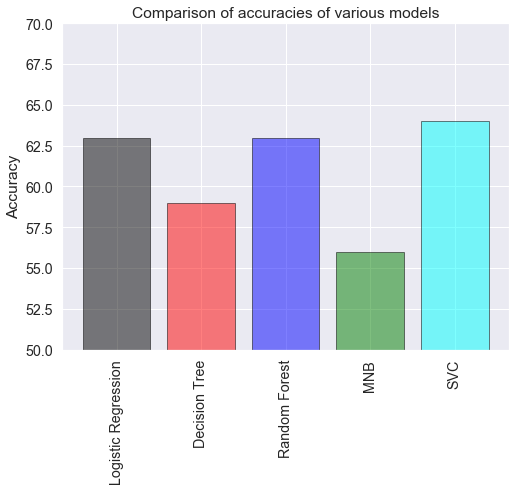

In [60]:
classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'MNB', 'SVC']
accuracies = [63.0,59.0,63.0,56.0,64.0]
plt.figure(4, [8,6])
plt.bar(range(len(classifiers)), accuracies, align='center', alpha=0.5,edgecolor='black',color=['black', 'red', 'blue', 'green','cyan'])
plt.xticks(range(len(classifiers)), classifiers, rotation=90)
plt.ylabel('Accuracy')
plt.title('Comparison of accuracies of various models')
plt.ylim([50,70])
plt.show()

In [39]:
df1_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,clean_text
0,16,95,0,0,0,0,0,0,0,0,0,audience prototyping tool use sketchbookssharpie pen photoshop balsamic google doc axsure etc
1,12,51,0,0,0,0,0,0,0,0,0,terminal sxsw send best photo amp video link
2,16,70,0,0,0,0,0,0,0,0,0,mention picture winning ipad cc mention mention link cont link
3,21,94,0,0,0,0,0,0,0,0,0,google marissa mayer mobile phone cursor physical location new version map fast real life like
4,8,34,0,0,0,0,0,0,0,0,0,google map even cooler thought


In [40]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

X = Xt
y = df_model.sentiment

In [41]:
#### As the target column was imbalanced, we decided to use stratify
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

In [42]:
!pip install imblearn

  Using cached https://files.pythonhosted.org/packages/81/a7/4179e6ebfd654bd0eac0b9c06125b8b4c96a9d0a8ff9e9507eb2a26d2d7e/imblearn-0.0-py2.py3-none-any.whl


In [43]:
# pip install -U imbalanced-learn

In [44]:
def model_scores(y_test,y_pred):
    print("F1 score is : ",f1_score(y_test,y_pred,average="weighted"),"\n Accuracy is : ",accuracy_score(y_test,y_pred))
    
## OverSampling
from imblearn.over_sampling import SMOTE,RandomOverSampler
smote = SMOTE(random_state=0)
X_train,y_train = smote.fit_sample(X_train,y_train)
logreg = LogisticRegression(max_iter=250,random_state=0)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
model_scores(y_test,y_pred)

F1 score is :  0.6306395898185216 
 Accuracy is :  0.6234539624370132


## Modelling

In [45]:
# Now using SVC on train and test both with TF-IDF vectoriser

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)


def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    return f1


#training
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred


# Storing the Id column of test data
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.636
1    1347
2     444
0      28
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,2
3,7688,2
4,3294,2


In [46]:
# Logistic Reg with TF-IDF Vectoriser

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()        # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(4)
    return f1

#training
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred


# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.6278
1    1362
2     439
0      18
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [47]:
# Logistic Reg with Count Vectorizer

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
CV = CountVectorizer()   # CountVectorizer()
Xc = CV.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = CV.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()       # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    
    return f1

#trainning
X = Xc
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred



# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.653
1    1250
2     504
0      64
3       1
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,2
3,7688,2
4,3294,2


In [48]:
# Logistic Reg with hashing Vectorizer
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
Hv = HashingVectorizer()       # HashinhVectorizer
Xh = Hv.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = Hv.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()         # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    return f1

#training
X = Xh
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred

# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.613
1    1406
2     398
0      15
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


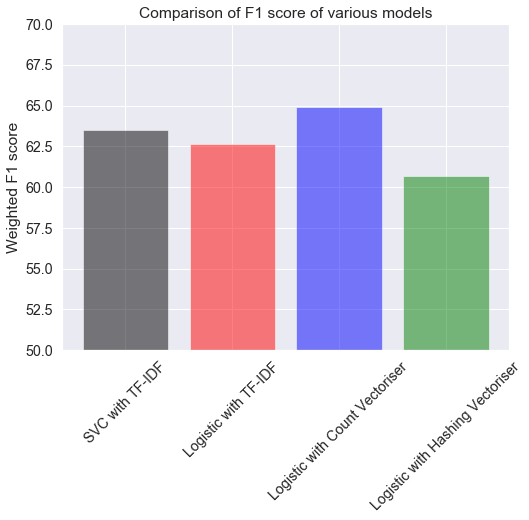

In [49]:
classifiers = ['SVC with TF-IDF', 'Logistic with TF-IDF', 'Logistic with Count Vectoriser', 'Logistic with Hashing Vectoriser']
Weighted_f1_score = [63.5,62.63,64.9,60.7]
plt.figure(4, [8,6])
plt.bar(range(len(classifiers)), Weighted_f1_score, align='center', alpha=0.5,color=['black', 'red', 'blue', 'green'])
plt.xticks(range(len(classifiers)), classifiers, rotation=45)
plt.ylabel('Weighted F1 score')
plt.title('Comparison of F1 score of various models')
plt.ylim([50,70])
plt.show()


In [50]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

X = Xt
y = df_model.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

## Hyperparameter Tuning

In [51]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
lsvm = LinearSVC(random_state=0)
parameter = {"penalty":["l1","l2"],
            "C":[0,0.01,0.1,0.8,1,1.2],
            "max_iter":[150,300,500,1000]}
random = RandomizedSearchCV(estimator=lsvm,param_distributions=parameter,scoring="f1_weighted",verbose=1,n_jobs=-1)
random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished


RandomizedSearchCV(estimator=LinearSVC(random_state=0), n_jobs=-1,
                   param_distributions={'C': [0, 0.01, 0.1, 0.8, 1, 1.2],
                                        'max_iter': [150, 300, 500, 1000],
                                        'penalty': ['l1', 'l2']},
                   scoring='f1_weighted', verbose=1)

In [52]:
random.best_params_,random.best_score_

({'penalty': 'l2', 'max_iter': 1000, 'C': 0.8}, 0.6455750213133087)

In [53]:
lsvm = LinearSVC(random_state=0,penalty='l2',max_iter=300,C=1)
lsvm.fit(X_train,y_train)
y_pred = lsvm.predict(X_test)
model_scores(y_test,y_pred)

F1 score is :  0.6557917025405867 
 Accuracy is :  0.672852233676976


In [54]:
grid = GridSearchCV(estimator=lsvm,param_grid=parameter,scoring="f1_weighted",n_jobs=-1,cv=10,verbose=1)
grid.fit(X_train,y_train)
grid.best_params_,grid.best_score_

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    7.7s finished


({'C': 1.2, 'max_iter': 150, 'penalty': 'l2'}, 0.6564193454839551)

In [55]:
lsvm = LinearSVC(random_state=0,penalty='l2',max_iter=150,C=0.1)
lsvm.fit(X_train,y_train)
y_pred = lsvm.predict(X_test)
model_scores(y_test,y_pred)

F1 score is :  0.6029333463045219 
 Accuracy is :  0.6542955326460481


In [56]:
rf = RandomForestClassifier()
parameters = {"n_estimators":[10,100],
              'criterion':['gini','entropy'],
             'max_depth':[20,60,'None','sqrt'],
            "max_features":[10,100,200],
             'bootstrap':['True','False']}
random = RandomizedSearchCV(estimator=rf,param_distributions=parameters,scoring="f1_weighted",verbose=1,n_jobs=-1)
random.fit(X_train,y_train)
random.best_params_,random.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.2s finished


({'n_estimators': 10,
  'max_features': 100,
  'max_depth': 60,
  'criterion': 'gini',
  'bootstrap': 'False'},
 0.5809742050253637)

In [57]:
rf = RandomForestClassifier(n_estimators= 100,
 max_features= 200,
 max_depth= 60,
 criterion= 'entropy',
 bootstrap= 'False')
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
model_scores(y_test,y_pred)

F1 score is :  0.6063674676201646 
 Accuracy is :  0.6570446735395189


# **After training diffrent models we get the best model for this data is `Linear SVC` due to very less variance and best fit compare to other models**

In [58]:
# Now using SVC on train and test both with TF-IDF vectoriser

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)


def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
#     model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
    model = LinearSVC(random_state=0,penalty='l2',max_iter=300,C=1)
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    return f1


#training
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred


# Storing the Id column of test data
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
submission.to_csv('submission.csv',index=False)

f1 score is: 0.656
1    1217
2     529
0      68
3       5
Name: sentiment, dtype: int64
